<a href="https://colab.research.google.com/github/jejjohnson/research_notebook/blob/develop/content/notes/egps/notebooks/gpytorch_egp_taylor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Process Gradients with GPyTorch

In this notebook, I will be looking at how one can compute the gradients of different


**Sources**

* [PyTorch Forum](https://discuss.pytorch.org/t/how-to-get-higher-order-gradients-w-r-t-inputs/50595) comment by Thomas V
* [PyTorch Issue](https://github.com/pytorch/pytorch/issues/4896) comment & [Gist Example](https://gist.github.com/apaszke/226abdf867c4e9d6698bd198f3b45fb7) by Adam Paszke

In [1]:
#@title Install Packages
try:
    import gpytorch
except:
    !pip install --upgrade pyro-ppl gpytorch pytorch-lightning tqdm wandb "git+https://github.com/uncertainty-toolbox/uncertainty-toolbox.git"

In [2]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# PyTorch Settings
import torch

# Pyro Settings

# GPyTorch Settings
import gpytorch

# PyTorch Lightning Settings

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import tqdm
import wandb

%load_ext autoreload
%autoreload 2

## 1D Datasets

In [3]:
def regression_near_square(
    n_train: int = 50,
    n_test: int = 1_000,
    x_noise: float = 0.3,
    y_noise: float = 0.2,
    seed: int = 123,
    buffer: float = 0.1,
):
    rng = np.random.RandomState(seed)

    # function
    f = lambda x: np.sin(1.0 * np.pi / 1.6 * np.cos(5 + 0.5 * x))

    # input training data (clean)
    xtrain = np.linspace(-10, 10, n_train).reshape(-1, 1)
    ytrain = f(xtrain) + rng.randn(*xtrain.shape) * y_noise
    xtrain_noise = xtrain + x_noise * rng.randn(*xtrain.shape)

    # output testing data (noisy)
    xtest = np.linspace(-10.0 - buffer, 10.0 + buffer, n_test)[:, None]
    ytest = f(xtest)
    xtest_noise = xtest + x_noise * rng.randn(*xtest.shape)

    idx_sorted = np.argsort(xtest_noise, axis=0)
    xtest_noise = xtest_noise[idx_sorted[:, 0]]
    ytest_noise = ytest[idx_sorted[:, 0]]

    return xtrain, xtrain_noise, ytrain, xtest, xtest_noise, ytest, ytest_noise

In [132]:
n_train = 60
n_test = 1_000
x_noise = 0.3
y_noise = 0.05
seed = 123


(
    Xtrain,
    Xtrain_noise,
    ytrain,
    xtest,
    xtest_noise,
    ytest,
    ytest_noise,
) = regression_near_square(
    n_train=n_train, n_test=n_test, x_noise=x_noise, y_noise=0.05, seed=123, buffer=0.3
)

x_stddev = np.array([x_noise])


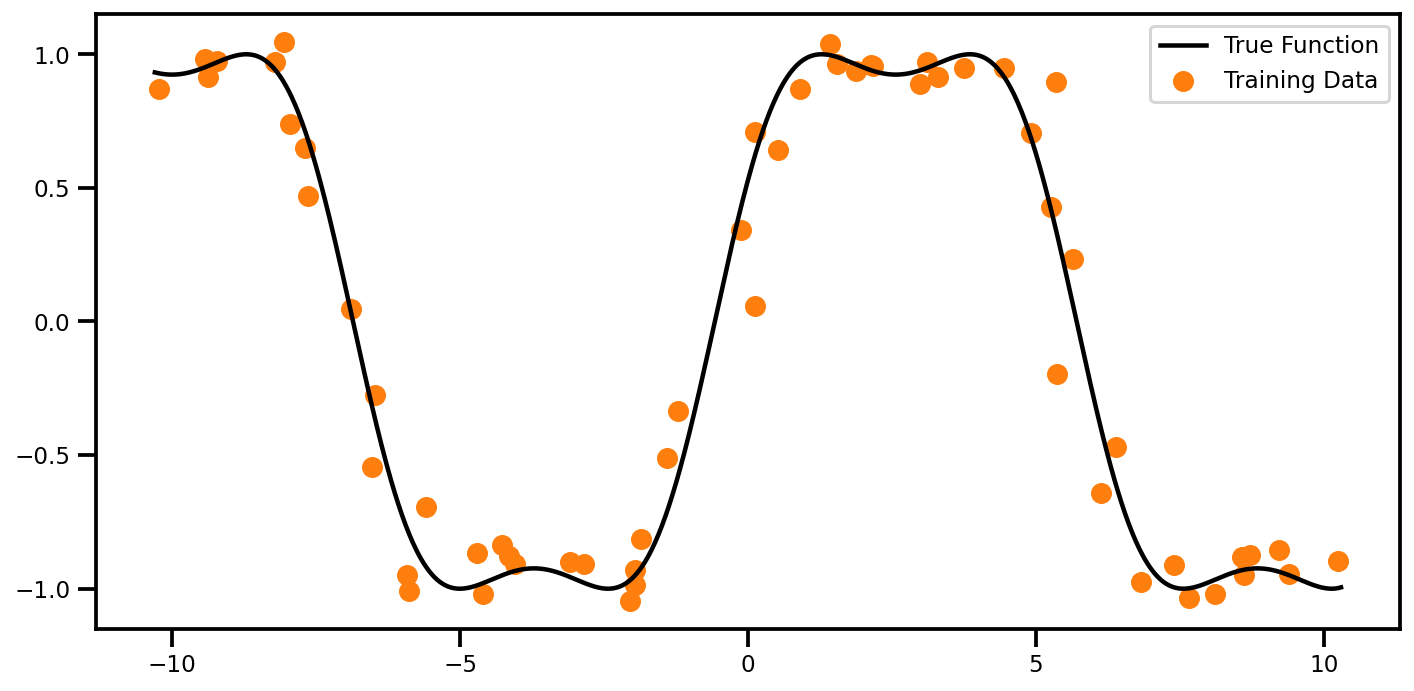

In [133]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(Xtrain_noise, ytrain, color="tab:orange", label="Training Data")
ax.plot(xtest, ytest, color="black", label="True Function")
ax.legend()
plt.tight_layout()
plt.show()

### Data

In [134]:
xtrain_tensor = torch.Tensor(Xtrain_noise)
ytrain_tensor = torch.Tensor(ytrain.squeeze())
xtest_tensor = torch.Tensor(xtest_noise)
ytest_tensor = torch.Tensor(ytest_noise)

if torch.cuda.is_available():
    print("Cuda!")
    xtrain_tensor, ytrain_tensor, xtest_tensor, ytest_tensor = xtrain_tensor.cuda(), ytrain_tensor.cuda(), xtest_tensor.cuda(), ytest_tensor.cuda()


## Plots

### Predictions

In [135]:
def plot_predictions(mu, lower, upper, noisy=True):
    fig, ax = plt.subplots(figsize=(10, 5))
    if noisy:
        ax.scatter(xtest_noise, ytest_noise, marker="o", s=30, color="tab:orange", label="Noisy Test Data")
    else:
        ax.scatter(xtest, ytest, marker="o", s=30, color="tab:orange", label="Noisy Test Data")
    ax.plot(xtest, ytest, color="black", linestyle="-", label="True Function")
    ax.plot(
        xtest,
        mu.ravel(),
        color="Blue",
        linestyle="--",
        linewidth=3,
        label="Predictive Mean",
    )
    ax.fill_between(
        xtest.ravel(),
        lower,
        upper,
        alpha=0.4,
        color="tab:blue",
        label=f" 95% Confidence Interval",
    )
    ax.plot(xtest, lower, linestyle="--", color="tab:blue")
    ax.plot(xtest, upper, linestyle="--", color="tab:blue")
    plt.tight_layout()
    plt.legend(fontsize=12)
    return fig, ax

### Calibrations

In [136]:
from uncertainty_toolbox import viz as utviz


def plot_all_uncertainty(
    y_pred, y_std, y_true,
):

    utviz.plot_calibration(y_pred=y_pred.ravel(), y_std=y_std.ravel(), y_true=y_true.ravel())

    return None

## Model

In [137]:

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)




### Training

In [138]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(xtrain_tensor, ytrain_tensor, likelihood)

In [139]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

if torch.cuda.is_available():
    model.cuda()
    likelihood.cuda()


# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
losses = []
training_iter = 250
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0.5 * training_iter], gamma=0.1)

with tqdm.trange(training_iter) as pbar:
    for i in pbar:
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(xtrain_tensor)
        # Calc loss and backprop gradients
        loss = -mll(output, ytrain_tensor)
        losses.append(loss.item())
        pbar.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()



100%|██████████| 250/250 [00:01<00:00, 127.29it/s, loss=0.0698]


### Losses

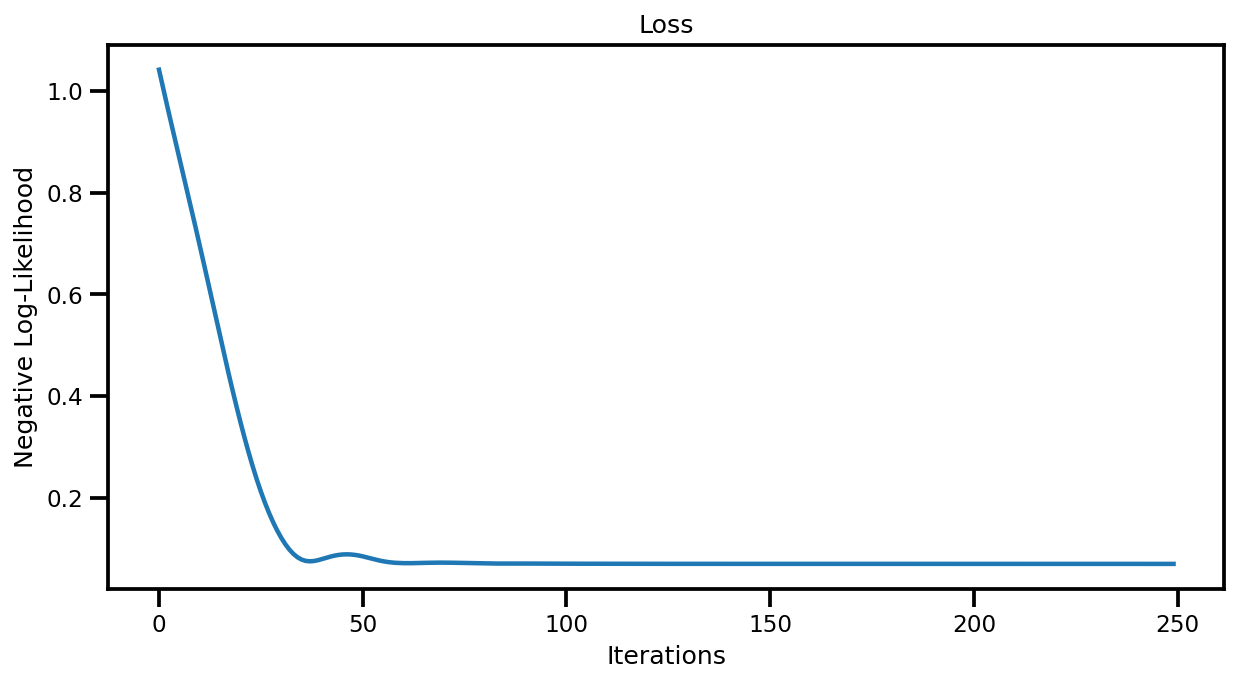

In [140]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="Negative Log-Likelihood")
plt.show()

### Predictions

In [141]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()


# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(xtest_tensor))

# get mean
if torch.cuda.is_available():
    mu = observed_pred.mean.cpu().numpy()
    # get variance
    var = observed_pred.variance.cpu().numpy()
    std = np.sqrt(var.squeeze())
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    lower, upper = lower.cpu().numpy(), upper.cpu().numpy()
else:
    mu = observed_pred.mean.detach().numpy()
    # get variance
    var = observed_pred.variance.detach().numpy()
    std = np.sqrt(var.squeeze())
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    lower, upper = lower.detach().numpy(), upper.detach().numpy()

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa2f88235d0>)

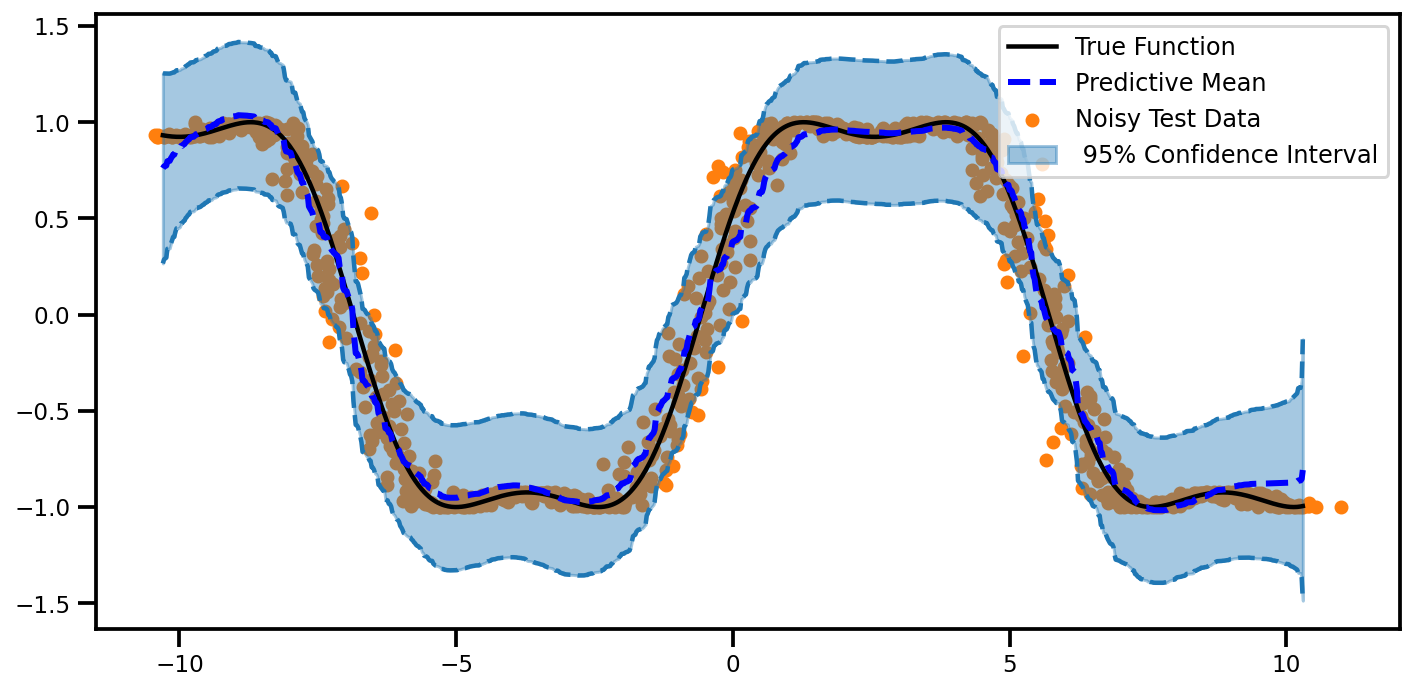

In [142]:
plot_predictions(mu, lower, upper)

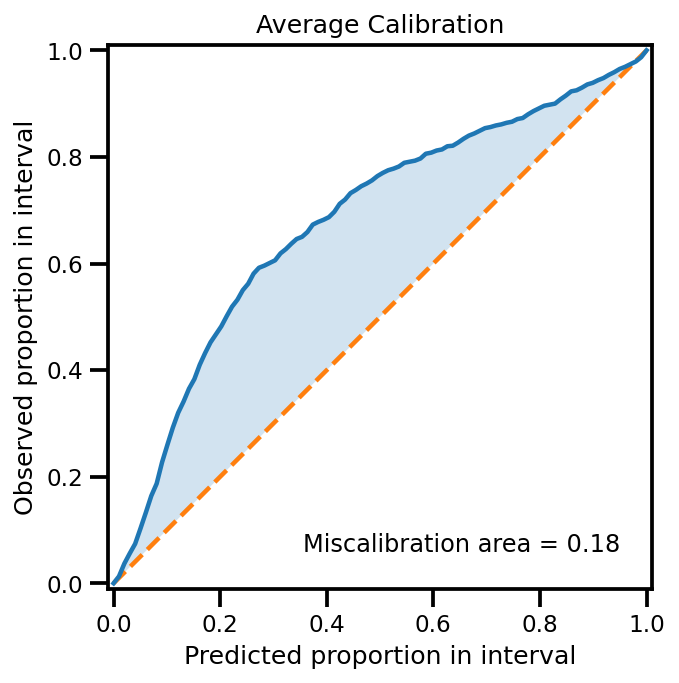

In [143]:
plot_all_uncertainty(mu, std, ytest_noise)

### Gradients w.r.t. Inputs (1st Derivative)

#### Tensors

In [144]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

X = torch.autograd.Variable(torch.Tensor(xtest_noise), requires_grad=True)
observed_pred = likelihood(model(X))
y = observed_pred.mean.sum()
y.backward()
dydtest_x = X.grad

#### AutoGrad

In [145]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

X = torch.autograd.Variable(torch.Tensor(xtest_noise), requires_grad=True)
observed_pred = likelihood(model(X))
dydtest_x_ag  = torch.autograd.grad(observed_pred.mean.sum(), X)[0]

#### Functional

In [146]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

X = torch.autograd.Variable(torch.Tensor(xtest_noise), requires_grad=True)

def f(X):
    return likelihood(model(X)).mean.sum()
dydtest_x_f  = torch.autograd.functional.jacobian(f, X)

### Plot

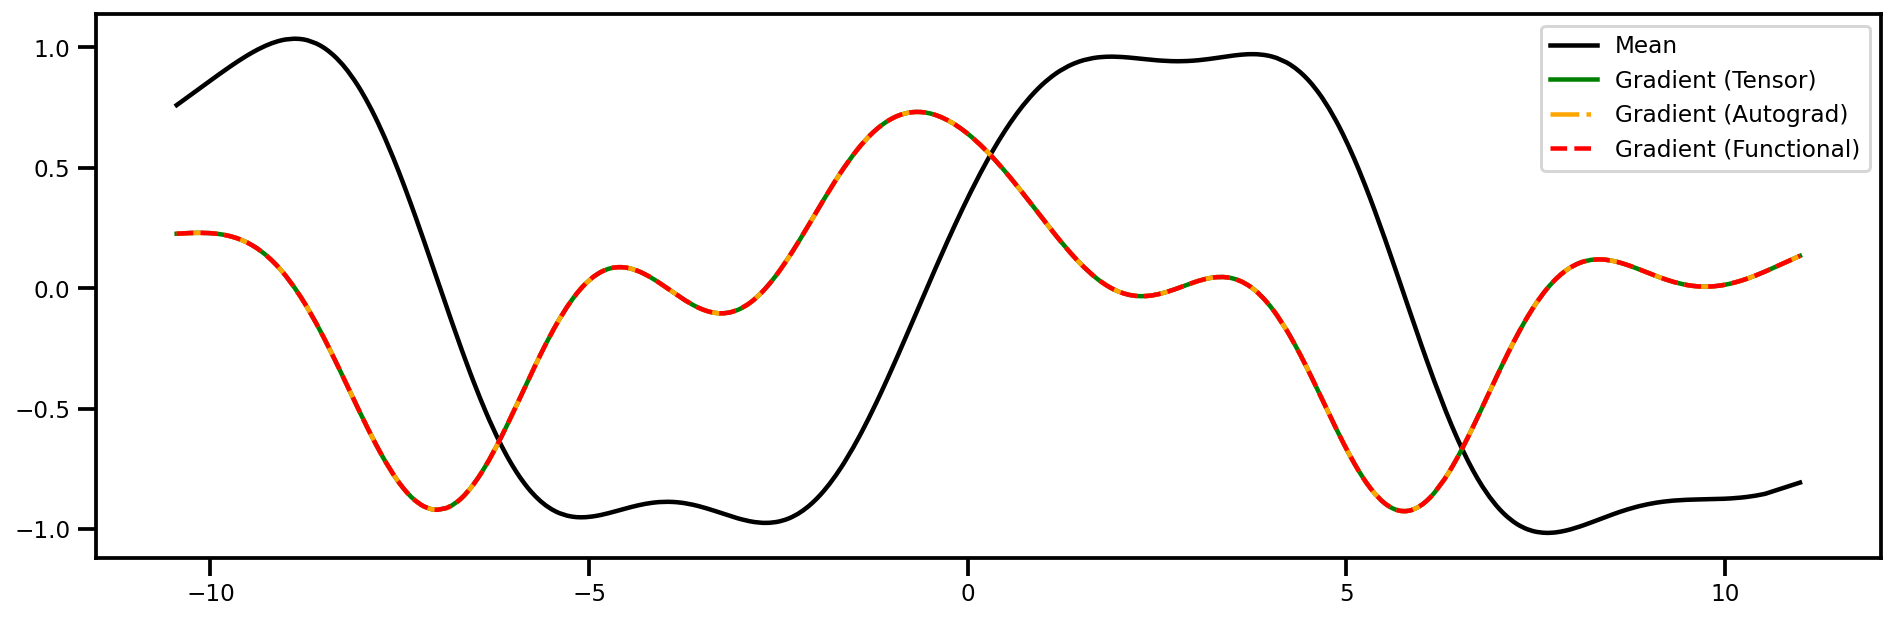

In [147]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(xtest_tensor.detach().numpy(), mu, color="black", label="Mean")
ax.plot(xtest_tensor.detach().numpy(), dydtest_x.detach().numpy(), 'green', label="Gradient (Tensor)")
ax.plot(xtest_tensor.detach().numpy(), dydtest_x_ag.detach().numpy(), 'orange', linestyle="-.", label="Gradient (Autograd)")
ax.plot(xtest_tensor.detach().numpy(), dydtest_x_f.detach().numpy(), 'red', linestyle="--", label="Gradient (Functional)")
plt.legend()
plt.show()

## Gradient (2nd Order) wrt Inputs

In [148]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

X = torch.autograd.Variable(torch.Tensor(xtest_noise), requires_grad=True)

def mean_f(X):
    return likelihood(model(X)).mean.sum()
def var_f(X):
    return likelihood(model(X)).var.sum()
def mean_df(X):
    return torch.autograd.functional.jacobian(mean_f, X, create_graph=True).sum()
def var_df(X):
    return torch.autograd.functional.jacobian(var_f, X, create_graph=True).sum()

dydtest_x_f  = torch.autograd.functional.jacobian(mean_f, X)
dy2dtest_x2_f  = torch.autograd.functional.jacobian(mean_df, X)

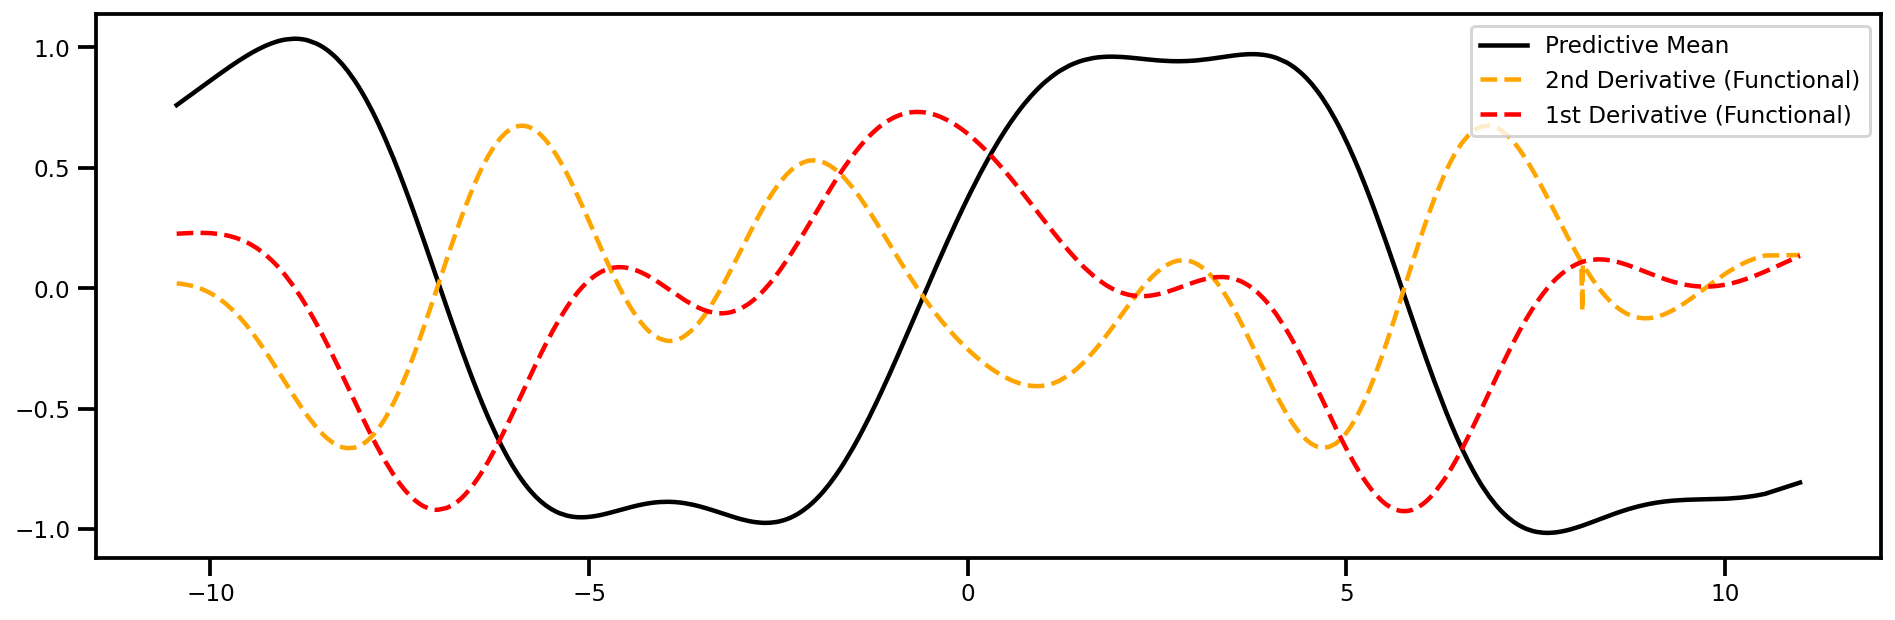

In [149]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(xtest_tensor.detach().numpy(), mu, color="black", label="Predictive Mean")
ax.plot(xtest_tensor.detach().numpy(), dy2dtest_x2_f.detach().numpy(), 'orange', linestyle="--", label="2nd Derivative (Functional)")
ax.plot(xtest_tensor.detach().numpy(), dydtest_x_f.detach().numpy(), 'red', linestyle="--", label="1st Derivative (Functional)")
plt.legend()
plt.show()

## Hessian (wrt Inputs)

In [150]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

X = torch.autograd.Variable(torch.Tensor(xtest_noise), requires_grad=True)


hessian_x_f  = torch.autograd.functional.hessian(mean_f, X)


Easy check is to see if the diagonal elements are the same as the 2nd Order derivative (i.e. Laplacian)

1. Permute the dimensions
2. Take the diagonal elements

In [151]:
hessian_x_f = hessian_x_f.permute(0, 2, 1, 3)

laplaced_x_f = hessian_x_f.diagonal().T

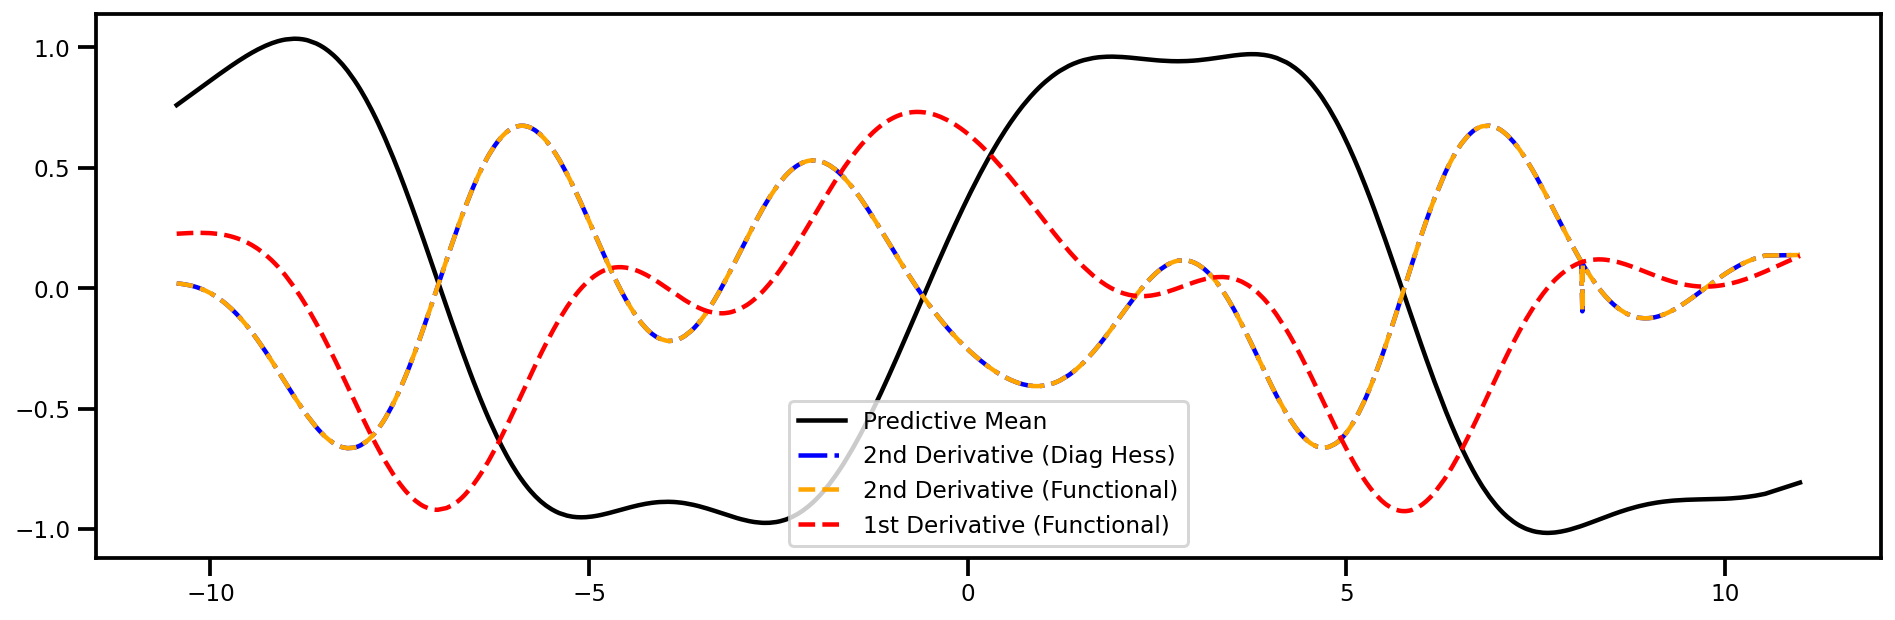

In [152]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(xtest_tensor.detach().numpy(), mu, color="black", label="Predictive Mean")
ax.plot(xtest_tensor.detach().numpy(), laplaced_x_f.detach().numpy()[..., 0], 'blue', linestyle="-.", label="2nd Derivative (Diag Hess)")
ax.plot(xtest_tensor.detach().numpy(), dy2dtest_x2_f.detach().numpy(), 'orange', linestyle="--", label="2nd Derivative (Functional)")
ax.plot(xtest_tensor.detach().numpy(), dydtest_x_f.detach().numpy(), 'red', linestyle="--", label="1st Derivative (Functional)")
plt.legend()
plt.show()

## Uncertain Inputs

A quick demo showing how we can use the Taylor Series Expansion to propagate the error within our inputs.





### 1st Order

$$
\begin{aligned}
\tilde{\mathbf{\mu}}_\text{LinGP}(\mathbf{x_*}) &= \mathbf{\mu}_\text{GP}(\mathbf{\mu}_\mathbf{x_*}) \\
\tilde{\mathbf{\sigma}}^2_\text{LinGP} (\mathbf{x_*}) &= 
\mathbf{\sigma}^2_\text{GP}(\mathbf{\mu}_\mathbf{x_*}) + 
\underbrace{\frac{\partial \mathbf{\mu}_\text{GP}(\mathbf{\mu}_\mathbf{x_*})}{\partial \mathbf{x_*}}^\top
\mathbf{\Sigma}_\mathbf{x_*}
\frac{\partial \mathbf{\mu}_\text{GP}(\mathbf{\mu}_\mathbf{x_*})}{\partial \mathbf{x_*}}}_\text{1st Order}
\end{aligned}
$$


In [153]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

X = torch.autograd.Variable(torch.Tensor(xtest_noise), requires_grad=True)

def mean_f(X):
    return likelihood(model(X)).mean.sum()
def mean_df(X):
    return torch.autograd.functional.jacobian(mean_f, X)

def hessian_mean_f(X):
    return None
hessian_x_f  = torch.autograd.functional.hessian(mean_f, X)
mu_jac  = mean_df(X)

In [154]:
input_cov = np.array([x_noise**2]).reshape(-1,1)
input_cov = torch.Tensor(input_cov)

In [155]:
var_corr = mu_jac.matmul(input_cov).matmul(mu_jac.t()).diagonal()
std_corr = var_corr.sqrt().detach().numpy()
egp_std = std + std_corr
egp_lower = mu - 1.96 * egp_std
egp_upper = mu + 1.96 * egp_std

#### Predictions

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa2f823a910>)

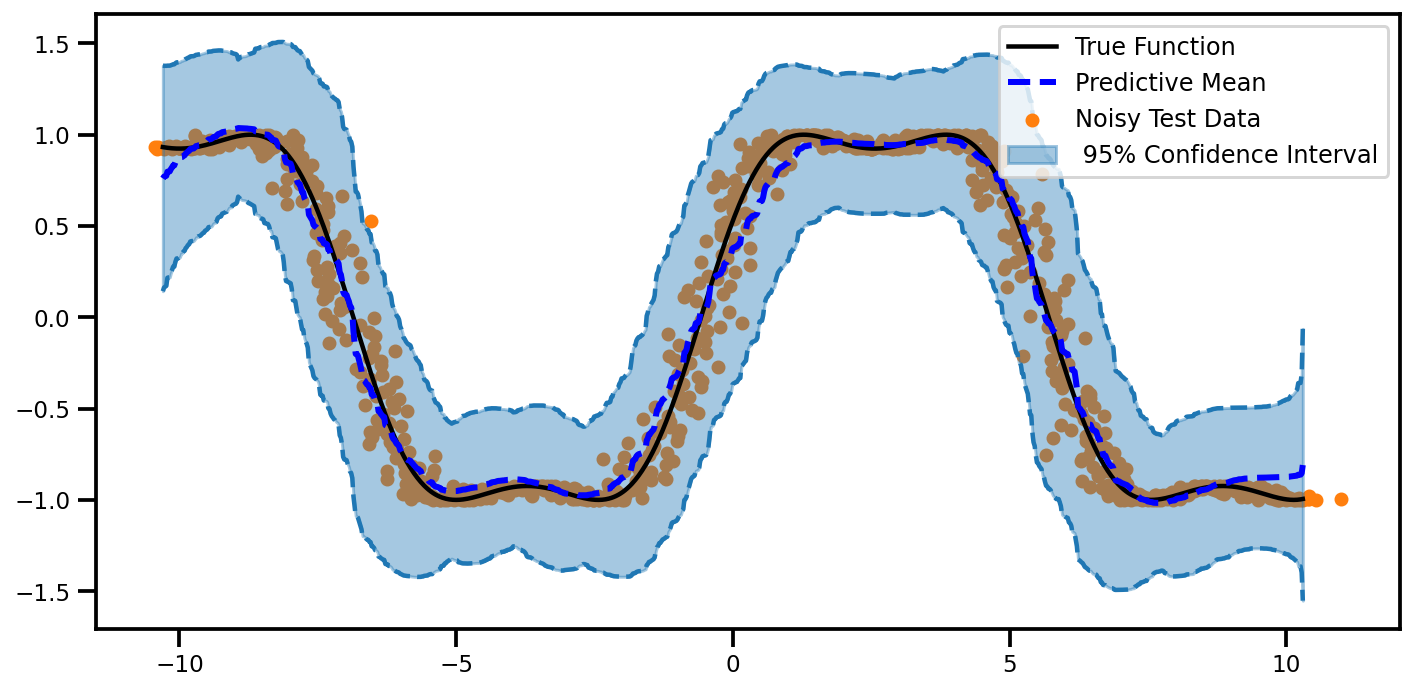

In [156]:
plot_predictions(mu, egp_lower, egp_upper)

#### Calibration

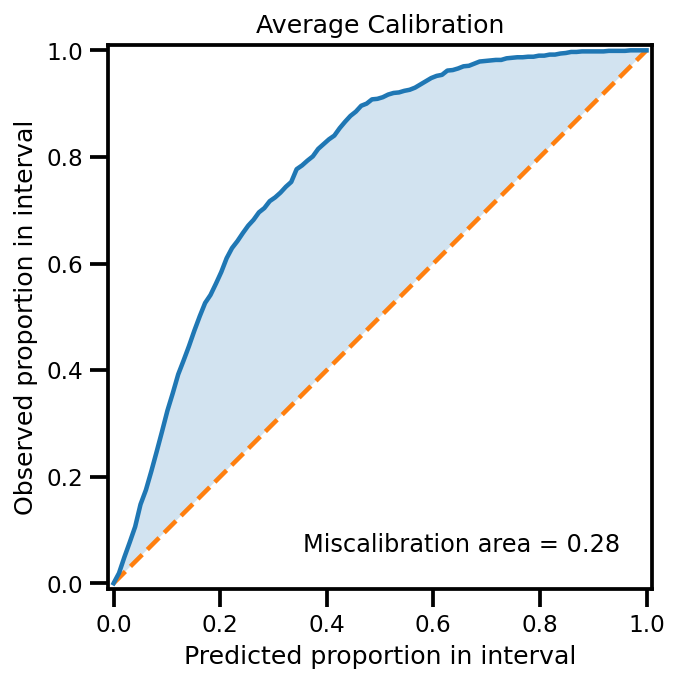

In [157]:
plot_all_uncertainty(mu, egp_std, ytest_noise)

### 2nd Order

$$
\begin{aligned}
\tilde{\mathbf{\mu}}_\text{LinGP}(\mathbf{x_*}) &= \mathbf{\mu}_\text{GP}(\mathbf{\mu}_\mathbf{x_*}) +
\underbrace{\frac{1}{2} \text{Tr}\left\{ \frac{\partial^2 \mathbf{\mu}_\text{GP}(\mathbf{\mu}_\mathbf{x_*})}{\partial \mathbf{x_*} \partial \mathbf{x_*}^\top}  \mathbf{\Sigma}_\mathbf{x_*}\right\}}_\text{second Order}\\
\tilde{\mathbf{\sigma}}^2_\text{LinGP} (\mathbf{x_*}) &= 
\mathbf{\sigma}^2_\text{GP}(\mathbf{\mu}_\mathbf{x_*}) + 
\underbrace{\frac{\partial \mathbf{\mu}_\text{GP}(\mathbf{\mu}_\mathbf{x_*})}{\partial \mathbf{x_*}}^\top
\mathbf{\Sigma}_\mathbf{x_*}
\frac{\partial \mathbf{\mu}_\text{GP}(\mathbf{\mu}_\mathbf{x_*})}{\partial \mathbf{x_*}}}_\text{1st Order} +
\underbrace{\frac{1}{2} \text{Tr}\left\{ \frac{\partial^2 \mathbf{\Sigma}^2_\text{GP}(\mathbf{\mu}_\mathbf{x_*})}{\partial \mathbf{x_*} \partial \mathbf{x_*}^\top}  \mathbf{\Sigma}_\mathbf{x_*}\right\}}_\text{2nd Order}
\end{aligned}
$$


In [158]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

X = torch.autograd.Variable(torch.Tensor(xtest_noise), requires_grad=True)


In [159]:
def _mean_f(X):
    return likelihood(model(X)).mean.sum()
def _var_f(X):
    return likelihood(model(X)).variance.sum()


def _jacobian_mean_f(X):
    return torch.autograd.functional.jacobian(_mean_f, X, create_graph=True).sum()
def _jacobian_var_f(X):
    return torch.autograd.functional.jacobian(_var_f, X, create_graph=True).sum()



def jacobian_meanf(X):
    return torch.autograd.functional.jacobian(_mean_f, X)

def laplacian_meanf(X):
    return torch.autograd.functional.jacobian(_jacobian_mean_f, X)

def laplacian_varf(X):
    return torch.autograd.functional.jacobian(_jacobian_var_f, X)

#### Predictive Mean

In [160]:
# mean term
mu_egp2 = mu.copy().reshape(-1, 1)

# correction term (2nd Order)
input_cov = np.array([x_noise**2]).reshape(-1,1)

mu_laplacian = laplacian_meanf(X).detach().numpy()
mu_corr = 0.5 * mu_laplacian @ input_cov



mu_egp2 += mu_corr#

#### Predictive Variance

In [161]:
# mean term
var_egp2 = var.copy().reshape(-1, 1)


# correction term (1nd Order)
mu_der = jacobian_meanf(X).detach().numpy()
var_corr = np.diag(mu_der @ input_cov @ mu_der.T).reshape(-1, 1)

var_egp2 += var_corr


# correction term (2nd Order)
mu_der2 = laplacian_varf(X).detach().numpy()
var_corr = 0.5 * mu_der2 @ input_cov

var_egp2 += var_corr



In [162]:
egp2_lower = mu_egp2 - 1.96 * np.sqrt(var_egp2)
egp2_upper = mu_egp2 + 1.96 * np.sqrt(var_egp2)

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa2f8339690>)

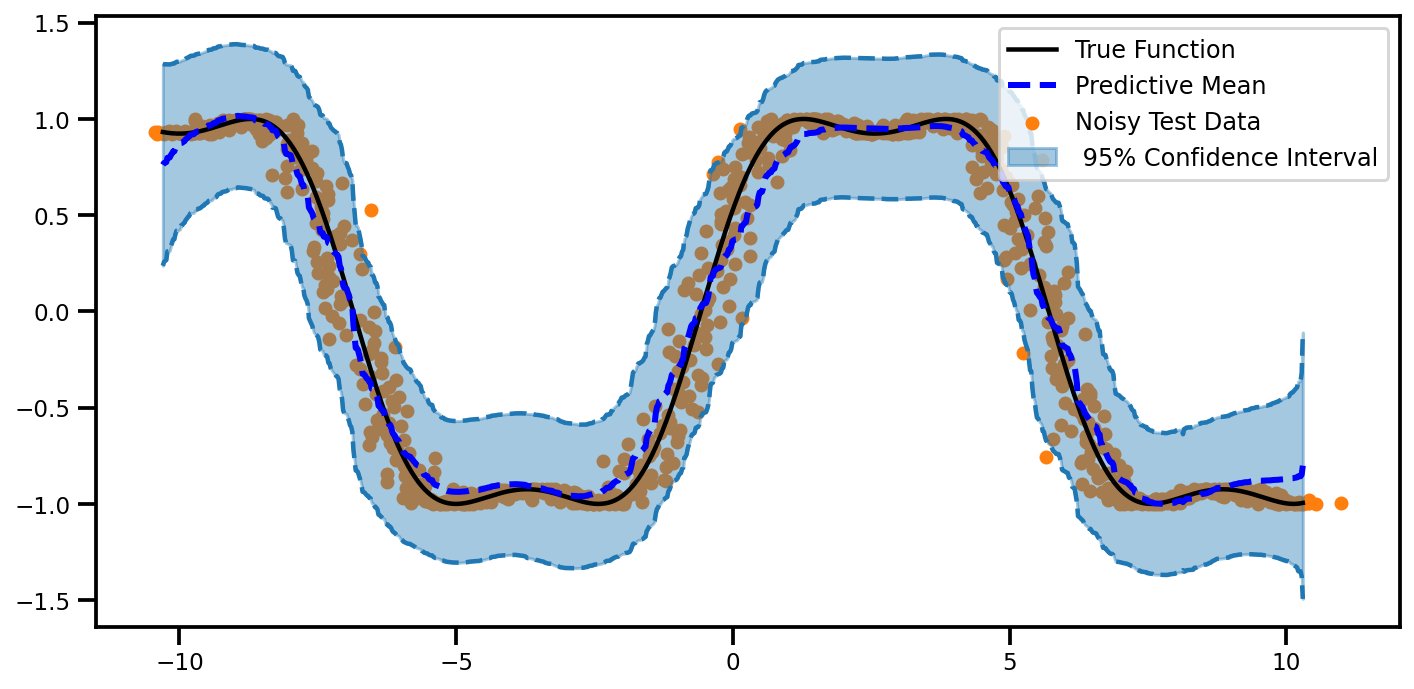

In [163]:
plot_predictions(mu_egp2.ravel(), egp2_lower.ravel(), egp2_upper.ravel())

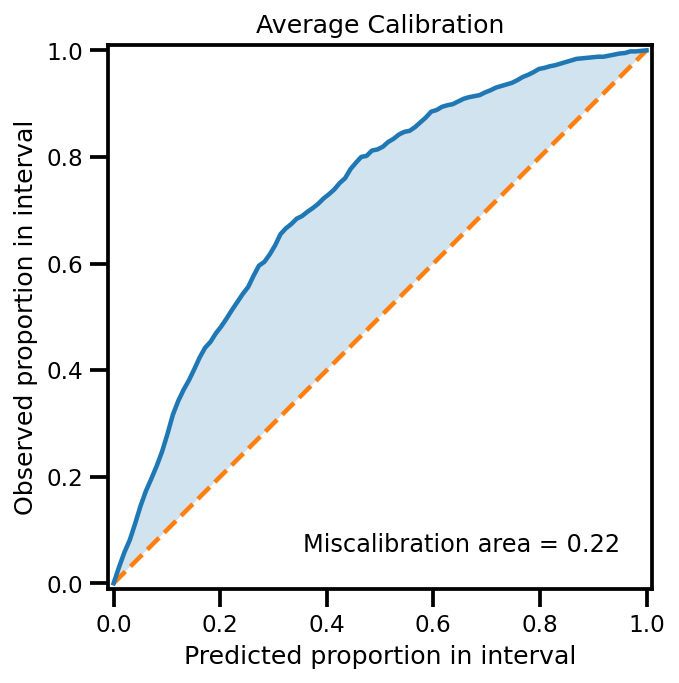

In [164]:
plot_all_uncertainty(mu_egp2, np.sqrt(var_egp2), ytest_noise)